# Дискретные случайные процессы и временные ряды, DS-поток
## Задание TS.5
### Поиск аномалий во временных рядах. Современные средства анализа временных рядов.

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.


**Баллы за задание.** 
  * Задача 1 &mdash; 80 баллов.
  * Задача 2 &mdash; 100 баллов.

In [1]:
# Bot check

# HW_ID: ds_ts5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [156]:
import warnings


warnings.filterwarnings("ignore")

In [157]:
import numpy as np
import pandas as pd
import scipy.stats as sps

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

#!pip install "etna@git+https://github.com/etna-team/etna.git@master"
from etna.datasets import TSDataset
from etna.pipeline import Pipeline
from etna.models import CatBoostPerSegmentModel
from etna.models import CatBoostMultiSegmentModel
from etna.transforms import LagTransform
from etna.transforms import DateFlagsTransform
from etna.transforms import FourierTransform
from etna.transforms import MeanTransform
from etna.transforms import YeoJohnsonTransform
from etna.transforms import SegmentEncoderTransform
from etna.metrics import MSE
from etna.metrics import MAE
from etna.metrics import MAPE

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

---

### Задача 1

Вам [выдана](https://disk.yandex.ru/d/d9uxKFsst-YBkA) часть информации о визитах пользователей на сайте Физтех.Статистики начиная с 2020 года по данным Яндекс.Метрики. Визит — последовательность действий пользователя на сайте, которая
начинается на некоторой странице сайта, содержит в себе переходы по ссылкам (и другие действия), и
заканчивается на какой-то, возможно, другой страницей сайта. Визит считается завершенным, если
активность отсутствует в течение некоторого времени, обычно — 30 минут.
Описание полей доступно по [ссылке](https://yandex.ru/dev/metrika/doc/api2/logs/fields/visits.html).

Для начала загрузим данные. Нас будет интересовать общее количество посещений по дням. Постройте график временного ряда, что можно о нем сказать?

In [10]:
data = pd.read_csv("miptstats_metrica.tsv", sep="\t")
data.columns = data.columns.str.replace(r'^ym:s:', '', regex=True)
data["dateTimeUTC"] = pd.to_datetime(data["dateTimeUTC"])

График посещений по дням

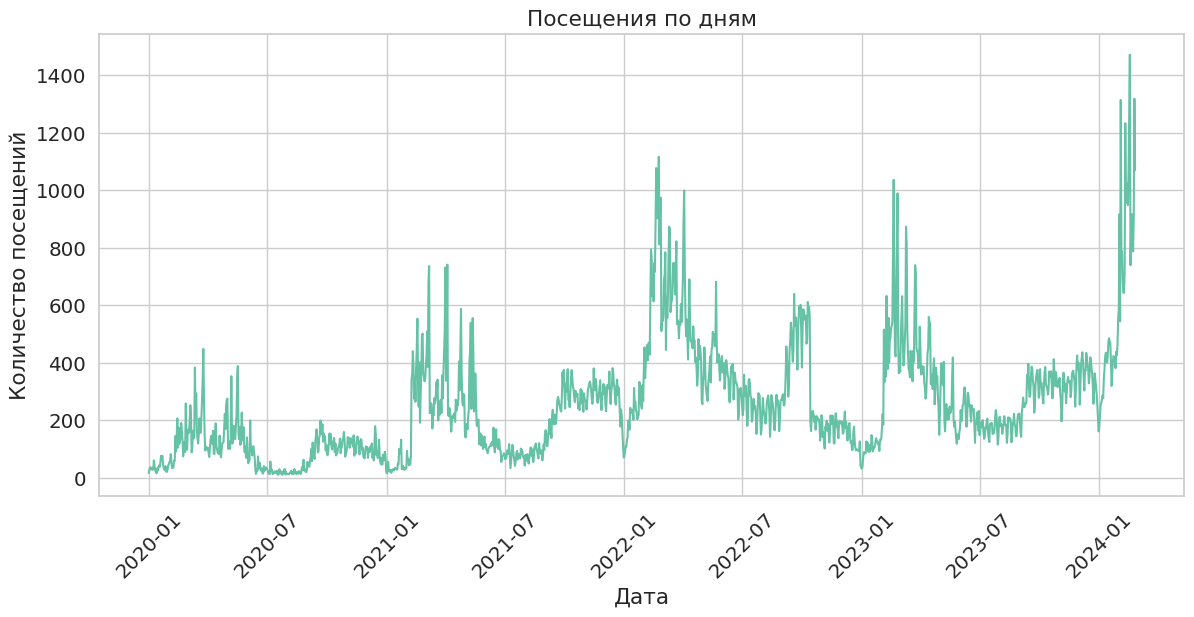

In [48]:
data_grouped = data.groupby(data["dateTimeUTC"].dt.date)['visitID'].count()

plt.figure(figsize=(14, 6))
plt.plot(data_grouped.index, data_grouped.values)
plt.xlabel("Дата")
plt.ylabel("Количество посещений")
plt.title("Посещения по дням")
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

Есть сезонные пики активности - осень и весна, летом активность ниже. Есть просто пики активности

Задачи:
* Найти аномалии в предоставленных временных рядах постфактум, то есть построить оффлайн-модель. Попробуйте применить методы на основе фильтрации или метрические методы с использованием, например, DBSCAN.
* Построить онлайн-модель детектирования аномалий.

Попробуйте проинтерпретировать найденные аномалии. С чем они могут быть связаны?

*Замечание.*

Если будете использовать метод Seasonal ESD, то можете воспользоваться библиотекой [`sesd`](https://pypi.org/project/sesd/).

Используем DBSCAN

In [53]:
X = np.array(data_grouped).reshape(-1, 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=0.6, min_samples=120)
dbscan.fit(X_scaled)

labels = dbscan.labels_
anomalies = data_grouped[labels == -1]

График аномалий

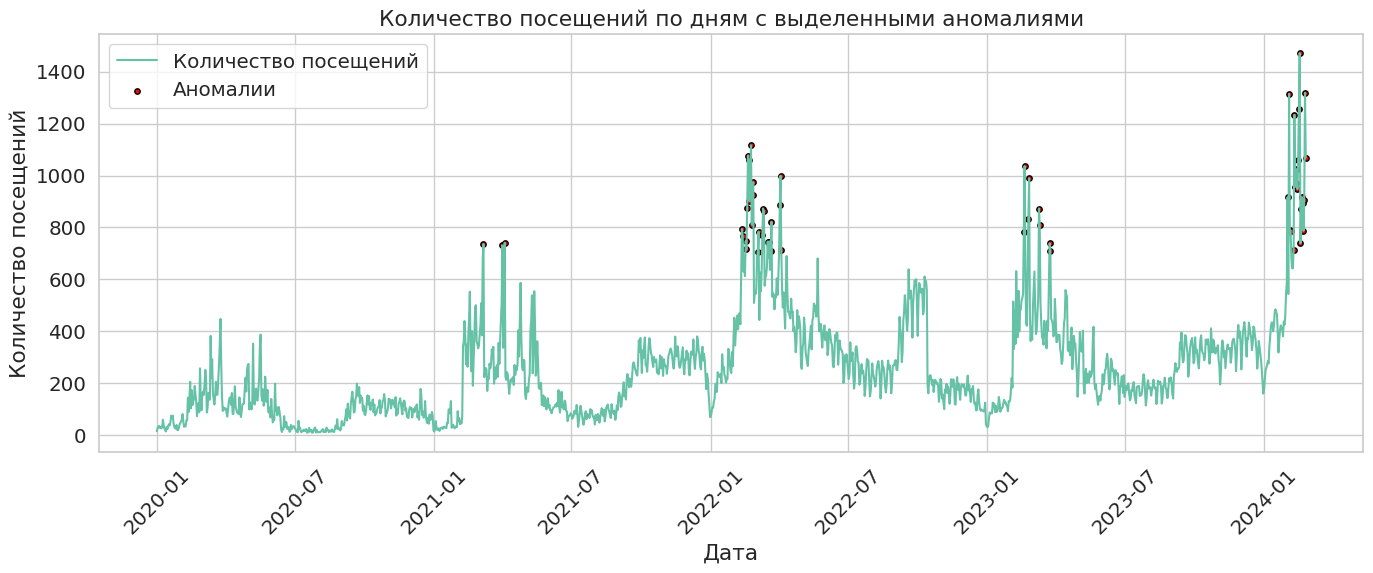

In [54]:
plt.figure(figsize=(14, 6))
plt.plot(data_grouped.index, data_grouped.values, label='Количество посещений')

plt.scatter(anomalies.index, anomalies.values, color='red', label='Аномалии', s=15, edgecolor='black')

plt.title('Количество посещений по дням с выделенными аномалиями')
plt.xlabel('Дата')
plt.ylabel('Количество посещений')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Онлайн модель Seasonal ESD

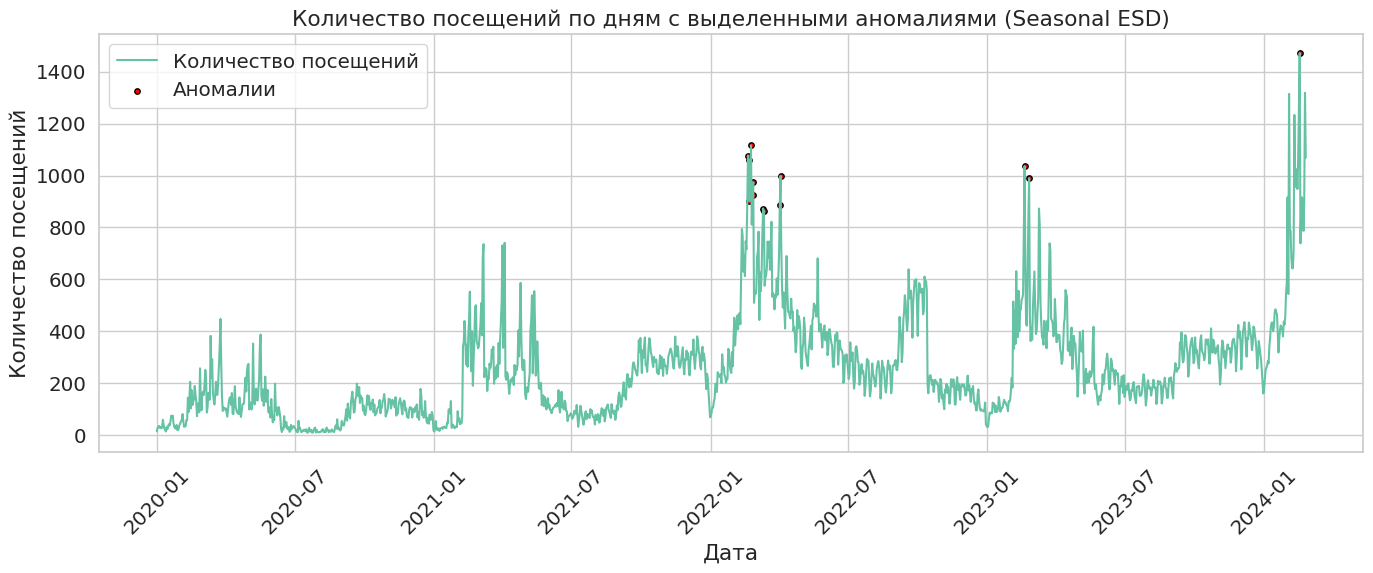

In [85]:
from sesd import seasonal_esd

data_grouped = data.groupby(data["dateTimeUTC"].dt.date)['visitID'].count()

data_grouped = data_grouped.reset_index()
data_grouped.columns = ['timestamp', 'value']
data_grouped['timestamp'] = pd.to_datetime(data_grouped['timestamp'])

anomalies_indices = seasonal_esd(
    ts=data_grouped['value'],
    hybrid=False, 
    max_anomalies=50,
    alpha=0.05
)

data_grouped['anomaly'] = 0
data_grouped.loc[anomalies_indices, 'anomaly'] = 1

plt.figure(figsize=(14, 6))

plt.plot(data_grouped['timestamp'] , data_grouped['value'], label='Количество посещений')

plt.scatter(data_grouped[data_grouped['anomaly'] == 1]['timestamp'],
            data_grouped[data_grouped['anomaly'] == 1]['value'],
            color='red', label='Аномалии', s=15, edgecolor='black')

plt.title('Количество посещений по дням с выделенными аномалиями (Seasonal ESD)')
plt.xlabel('Дата')
plt.ylabel('Количество посещений')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Модель плохо ловит сезонность и поэтому предсказание почти пустое

Теперь с помощью деревьев, сначала строим лес

In [89]:
import rrcf

num_trees = 40
shingle_size = 4
tree_size = 256

forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

Строим предсказание

In [92]:
# Генератор для создания потока окон-точек
points = rrcf.shingle(data_grouped['value'], size=shingle_size)

# Словарь степени аномальности каждой точки
avg_codisp = {}

# Для каждого окна
for index, point in enumerate(points):
    # для каждого дерева
    for tree in forest:
        # если дерево уже большое
        if len(tree.leaves) > tree_size:
            # удалим самую старую окно-точку
            tree.forget_point(index - tree_size)
        # добавим новую окно-точку
        tree.insert_point(point, index=index)
        # вычислим степень аномальности нового окна
        new_codisp = tree.codisp(index)
        # и усредним по всем деревьям
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += new_codisp / num_trees

Визуализация

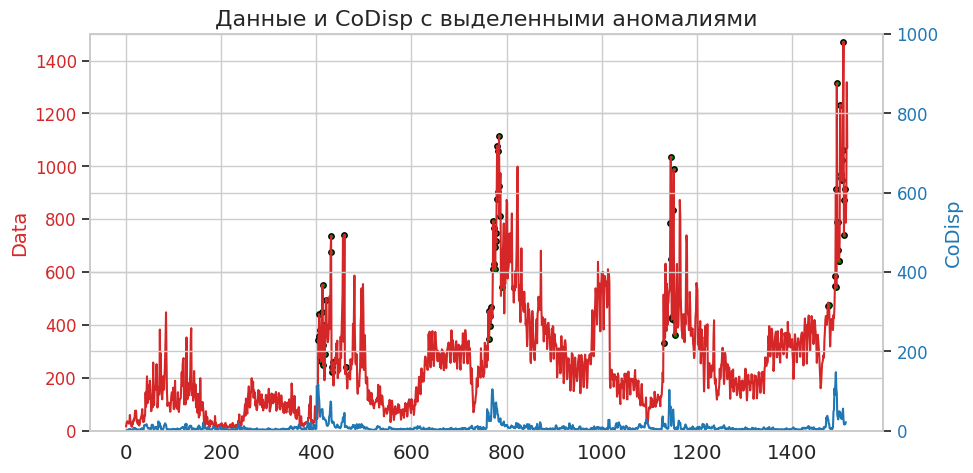

In [118]:
fig, ax1 = plt.subplots(figsize=(10, 5))

threshold = np.percentile(pd.Series(avg_codisp).values, 95)

k = len(data_grouped) - len(avg_codisp_series)

data_grouped_aligned = data_grouped.iloc[k:]

anomalies = data_grouped_aligned[pd.Series(avg_codisp).values > threshold]

color = "tab:red"
ax1.set_ylabel("Data", color=color, size=14)
ax1.plot(data_grouped['value'], color=color)
ax1.tick_params(axis="y", labelcolor=color, labelsize=12)
ax1.set_ylim(0, 1500)

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("CoDisp", color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis="y", labelcolor=color, labelsize=12)
ax2.grid("off")
ax2.set_ylim(0, 1000)

ax1.scatter(anomalies.index, anomalies['value'], color='green',
            label='Аномалии', s=15, edgecolor='black')

plt.title('Данные и CoDisp с выделенными аномалиями', size=16)
fig.tight_layout()
plt.show()

Последний метод так же ловит аномально низкие значения

Из сезонность по неделям можно предположить, что такие дни соответсвуют сдачам домашкам. Так же есть готовая сезонность - похоже на добавление Введения в АД

---

### Задача 2

Как и прежде, будем работать с [данными](https://www.kaggle.com/c/demand-forecasting-kernels-only/overview) соревнования по прогнозированию спроса на товары. Рассмотрите 5 некоторых магазинов и 20 товаров, которые продаются в них. Таким образом, вам предлагается работать с 100 временными рядами. Как и до этого, разделите данные на обучение и тест, оставив для прогнозирования 365 последних измерений. 

С использованием какого-нибудь фреймворка для работы с временными рядами, например, [ETNA](https://github.com/etna-team/etna), реализуйте и сравните следующие подходы к прогнозированию:

* Одна модель на все временные ряды
* Одна модель на товар, идентификатор магазина можно использовать как признак.
* Одна модель на магазин, идентификатор товара можно использовать как признак.
* Одна модель на каждый временной ряд, итого 100 моделей.

Используйте ML модель для табличных данных, например, какой-нибудь бустинг. Сравните результаты по метрике MAE, сделайте выводы.

In [204]:
df = pd.read_csv("train.csv", parse_dates=["date"])

selected_stores = [1, 2, 3, 4, 5]
selected_items = range(1, 21)

filtered_df = df[df['store'].isin(selected_stores) & df['item'].isin(selected_items)]

filtered_df = filtered_df.sort_values(by='date')

filtered_df["segment"] = (
    filtered_df["store"].astype(str).str.cat(filtered_df["item"].astype(str), sep="_")
)
filtered_df.rename({"date": "timestamp"}, axis=1, inplace=True)
filtered_df.rename({"sales": "target"}, axis=1, inplace=True)

data_endog = filtered_df[["timestamp", "segment", "target"]]
data_exog = filtered_df[["timestamp", "segment", "store", "item"]]

Создание датасета

In [205]:
HORIZON = 365
result = {}

ts = TSDataset(df=data_endog, freq="D")
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)
ts.head()

segment,1_1,1_10,1_11,1_12,1_13,1_14,1_15,1_16,1_17,1_18,...,5_19,5_2,5_20,5_3,5_4,5_5,5_6,5_7,5_8,5_9
feature,target,target,target,target,target,target,target,target,target,target,...,target,target,target,target,target,target,target,target,target,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,37,37,33,37,22,42,14,13,38,...,20,26,20,14,4,9,20,21,30,21
2013-01-02,11,34,43,35,31,35,33,11,18,51,...,12,22,14,16,5,5,15,16,23,20
2013-01-03,14,32,34,41,50,26,45,12,15,42,...,17,26,29,15,8,3,37,25,37,15
2013-01-04,13,45,52,45,45,32,39,15,19,50,...,24,23,16,15,7,12,33,28,39,20
2013-01-05,10,35,45,46,49,31,47,22,16,56,...,17,22,14,10,7,8,20,32,37,23


Первая модель котороя прогнозирует сразу все ряды

In [206]:
multi_segment_transforms = [
    YeoJohnsonTransform(in_column="target", inplace=True),
    LagTransform(
        in_column="target",
        lags=[HORIZON + i for i in range(100)],
        out_column="lag",
    ),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        is_weekend=True,
        out_column="date_flag",
    ),
    FourierTransform(period=365, order=20),
    MeanTransform(in_column=f"lag_{HORIZON}", window=10, seasonality=7),
    SegmentEncoderTransform()
]

multi_segment_model = CatBoostMultiSegmentModel()
pipeline = Pipeline(
    model=multi_segment_model,
    transforms=multi_segment_transforms,
    horizon=HORIZON,
)

Обучение

In [207]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, metrics=[MSE(), MAE(), MAPE()], n_folds=1, n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s


Среднее метрик

In [208]:
metrics_df[["MSE", "MAE", "MAPE"]].mean()

MSE     68.813866
MAE      6.349704
MAPE    12.045662
dtype: float64

Гистограмма MAPE

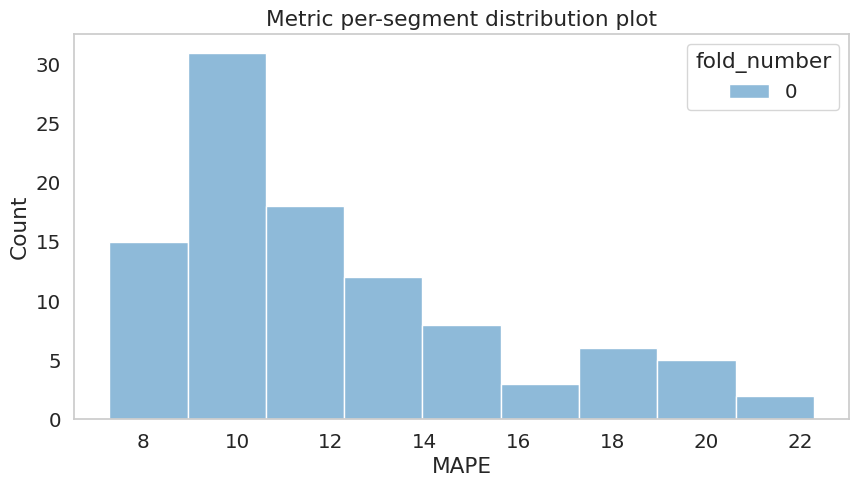

In [209]:
from etna.analysis import metric_per_segment_distribution_plot


metric_per_segment_distribution_plot(metrics_df=metrics_df, metric_name="MAPE")

Предсказания

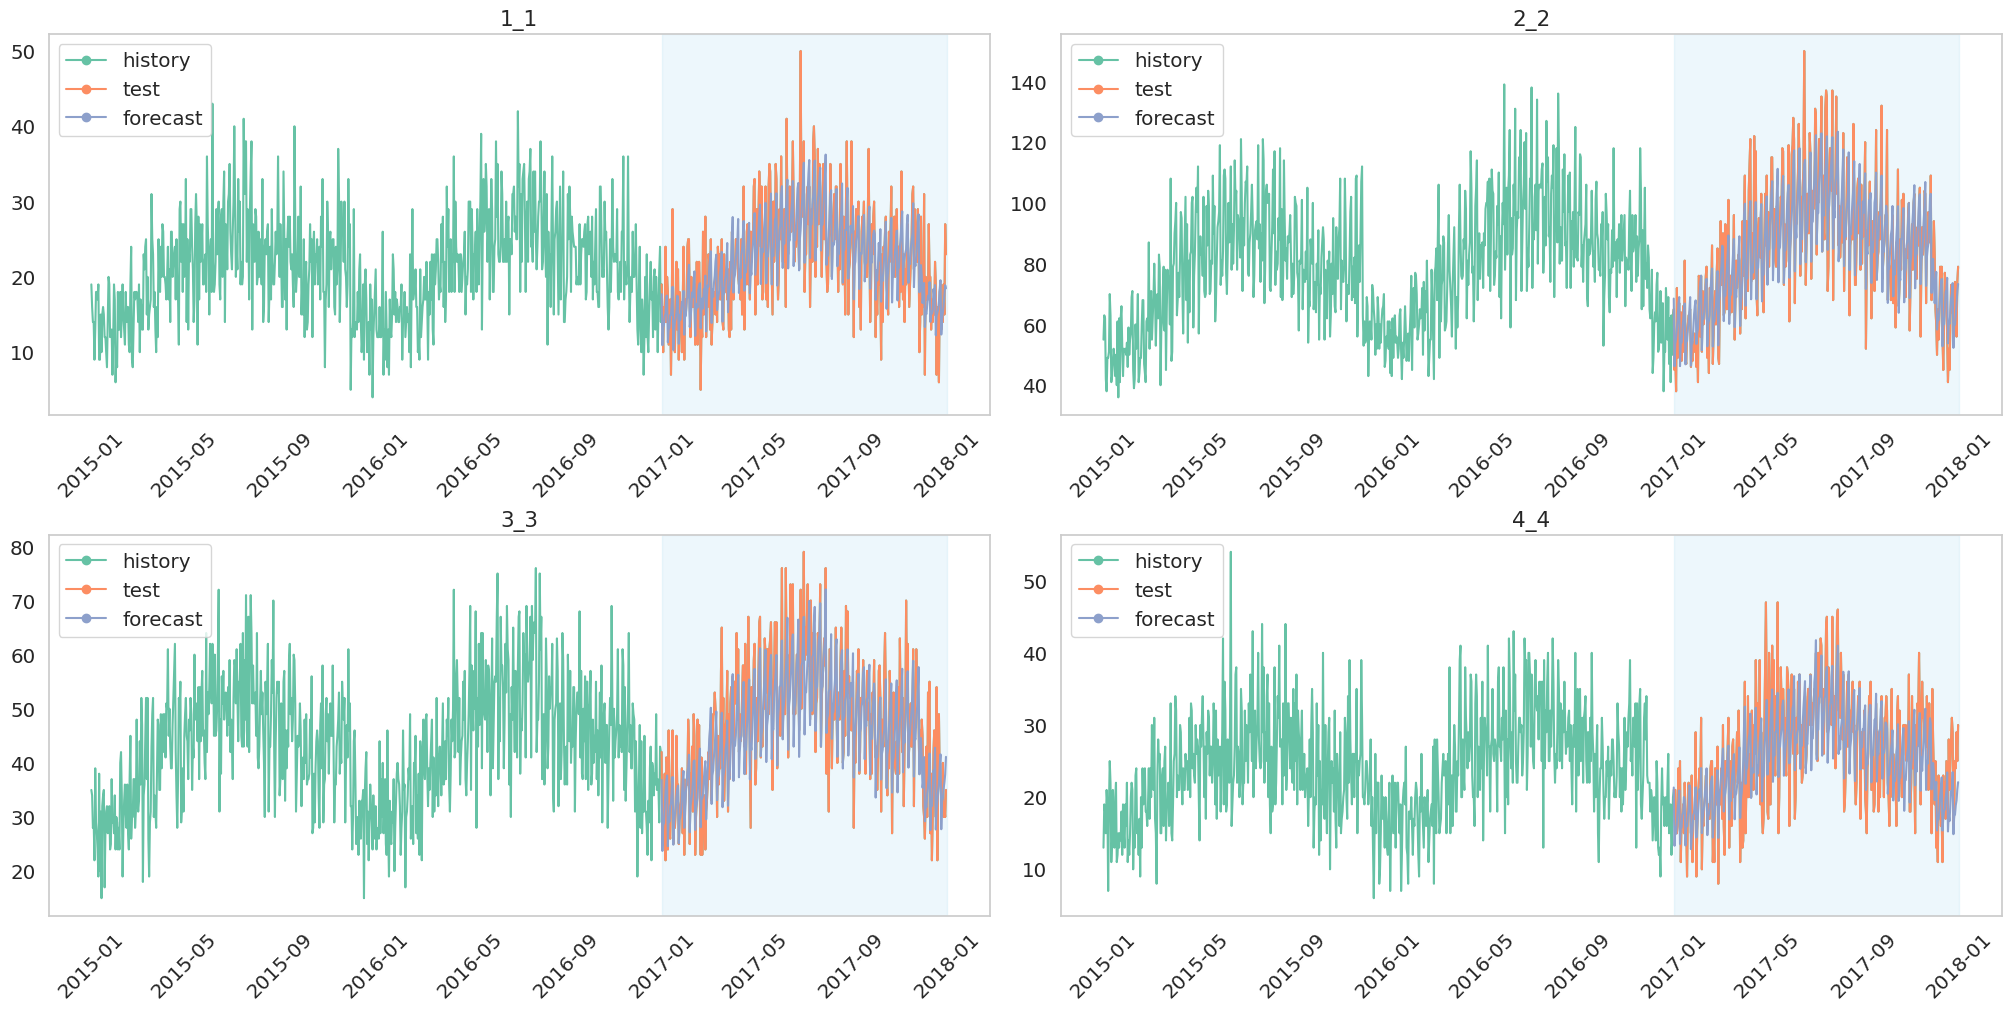

In [210]:
from etna.analysis import plot_backtest

plot_backtest(
    forecast_df=forecast_df,
    ts=ts,
    history_len=2 * HORIZON,
    segments=["1_1", "2_2", "3_3", "4_4"],
)

Результаты занесу в таблицу

In [213]:
def add_model_results(model_name, metrics_array):
    global result_metrics_df
    new_row = pd.DataFrame({
        "Model": [model_name],
        "MSE": [metrics_array[0]],
        "MAE": [metrics_array[1]],
        "MAPE": [metrics_array[2]]
    })
    result_metrics_df = pd.concat([result_metrics_df, new_row], ignore_index=True)
    return result_metrics_df 

Итак

In [214]:
result_metrics_df = pd.DataFrame(columns=["Model", "MSE", "MAE", "MAPE"])

add_model_results("One model for all", metrics_df[["MSE", "MAE", "MAPE"]].mean())

,Model,MSE,MAE,MAPE
0,One model for all,68.813866,6.349704,12.045662


2. Одна модель на товар

In [188]:
from tqdm.auto import tqdm

unique_items = filtered_df['item'].unique()

metrics_df_list, forecast_df_list, fold_info_df_list = [], [], []
for item in tqdm(unique_items, leave=False):
    item_df = filtered_df[filtered_df['item'] == item]
    
    ts = TSDataset(df=item_df[["timestamp", "segment", "target"]], freq="D")
    
    multi_segment_transforms = [
        YeoJohnsonTransform(in_column="target", inplace=True),
        LagTransform(
            in_column="target",
            lags=[HORIZON + i for i in range(100)],
            out_column="lag",
        ),
        DateFlagsTransform(
            day_number_in_week=True,
            day_number_in_month=True,
            is_weekend=True,
            out_column="date_flag",
        ),
        FourierTransform(period=365, order=20),
        MeanTransform(in_column=f"lag_{HORIZON}", window=10, seasonality=7),
        SegmentEncoderTransform()
    ]
    
    multi_segment_model = CatBoostMultiSegmentModel()
    
    pipeline = Pipeline(
        model=multi_segment_model,
        transforms=multi_segment_transforms,
        horizon=HORIZON,
    )

    metrics_df, forecast_df, fold_info_df = pipeline.backtest(
        ts=ts, metrics=[MSE(), MAE(), MAPE()], n_folds=1, n_jobs=-1
    )
    metrics_df_list.append(metrics_df)
    forecast_df_list.append(forecast_df)
    fold_info_df_list.append(fold_info_df)

  0%|          | 0/20 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1

In [225]:
all_metrics_df = pd.concat(metrics_df_list, ignore_index=True)

average_metrics = all_metrics_df[["MSE", "MAE", "MAPE"]].mean()
add_model_results("One model for one item", average_metrics)

,Model,MSE,MAE,MAPE
0,One model for all,68.813866,6.349704,12.045662
1,One model for one item,73.213099,6.563657,12.460222


3. Одна модель на магазин

In [191]:
metrics_df_list_shop = []
forecast_df_list_shop = []
fold_info_df_list_shop = []

unique_stores = filtered_df['store'].unique()

for store in tqdm(unique_stores, leave=False):
    store_df = filtered_df[filtered_df['store'] == store]
    
    ts = TSDataset(df=store_df[["timestamp", "segment", "target"]], freq="D")
    
    multi_segment_transforms = [
        YeoJohnsonTransform(in_column="target", inplace=True),
        LagTransform(
            in_column="target",
            lags=[HORIZON + i for i in range(100)],
            out_column="lag",
        ),
        DateFlagsTransform(
            day_number_in_week=True,
            day_number_in_month=True,
            is_weekend=True,
            out_column="date_flag",
        ),
        FourierTransform(period=365, order=20),
        MeanTransform(in_column=f"lag_{HORIZON}", window=10, seasonality=7),
        SegmentEncoderTransform()
    ]
    
    multi_segment_model = CatBoostMultiSegmentModel()
    
    pipeline = Pipeline(
        model=multi_segment_model,
        transforms=multi_segment_transforms,
        horizon=HORIZON,
    )

    metrics_df, forecast_df, fold_info_df = pipeline.backtest(
        ts=ts, metrics=[MSE(), MAE(), MAPE()], n_folds=1, n_jobs=-1
    )
    metrics_df_list_shop.append(metrics_df)
    forecast_df_list_shop.append(forecast_df)
    fold_info_df_list_shop.append(fold_info_df)

  0%|          | 0/5 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1

In [226]:
all_metrics_df = pd.concat(metrics_df_list_shop, ignore_index=True)

average_metrics = all_metrics_df[["MSE", "MAE", "MAPE"]].mean()
add_model_results("One model for one shop", average_metrics)

,Model,MSE,MAE,MAPE
0,One model for all,68.813866,6.349704,12.045662
1,One model for one item,73.213099,6.563657,12.460222
2,One model for one shop,70.781292,6.443576,12.253379


4. Одна модель на пару магазин-товар

In [192]:
metrics_df_list_segment = []
forecast_df_list_segment = []
fold_info_df_list_segment = []

unique_segments = filtered_df['segment'].unique()

for segment in unique_segments:
    segment_df = filtered_df[filtered_df['segment'] == segment]
    
    ts = TSDataset(df=segment_df[["timestamp", "segment", "target"]], freq="D")
    
    multi_segment_transforms = [
        YeoJohnsonTransform(in_column="target", inplace=True),
        LagTransform(
            in_column="target",
            lags=[HORIZON + i for i in range(100)],
            out_column="lag",
        ),
        DateFlagsTransform(
            day_number_in_week=True,
            day_number_in_month=True,
            is_weekend=True,
            out_column="date_flag",
        ),
        FourierTransform(period=365, order=20),
        MeanTransform(in_column=f"lag_{HORIZON}", window=10, seasonality=7),
        SegmentEncoderTransform()
    ]
    
    multi_segment_model = CatBoostMultiSegmentModel()
    
    pipeline = Pipeline(
        model=multi_segment_model,
        transforms=multi_segment_transforms,
        horizon=HORIZON,
    )
    
    metrics_df, forecast_df, fold_info_df = pipeline.backtest(
        ts=ts, metrics=[MSE(), MAE(), MAPE()], n_folds=1, n_jobs=-1
    )
    
    metrics_df_list_segment.append(metrics_df)
    forecast_df_list_segment.append(forecast_df)
    fold_info_df_list_segment.append(fold_info_df)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1

In [227]:
all_metrics_df = pd.concat(metrics_df_list_segment, ignore_index=True)

average_metrics = all_metrics_df[["MSE", "MAE", "MAPE"]].mean()
add_model_results("One model for one pair item-shop", average_metrics)

,Model,MSE,MAE,MAPE
0,One model for all,68.813866,6.349704,12.045662
1,One model for one item,73.213099,6.563657,12.460222
2,One model for one shop,70.781292,6.443576,12.253379
3,One model for one pair item-shop,80.984618,6.884244,12.994796


Сравнением модели по MAE. Лучшим вариантом оказалась единая модель для всех рядов (аж по всем метрикам). Она анализирует сразу все ряды, и может более точно выявить, например, тренд и сезонность, ведь у нее сразу много временных рядов. Кроме того, она сразу видит все продажи каждого из товаров и каждого из магазинов в отдельности - и видит тренды отдельно по магазинам / отдельно по товарам (модели из пунктов 1. 2. видят только один из таких двух видов срезов - и у них тоже качество лучше, чем у 3 - поэтому действительно дело в этом)

Таким образом, что несколько неожиданно, 1 модель победила 100, и не всегда больше моделей означает лучше